In [13]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *

In [14]:
env = gym.make('CartPole-v0')

[2017-04-04 02:34:13,938] Making new env: CartPole-v0


In [15]:
input_dim = env.observation_space.shape
output_dim = env.action_space.n

input_var = input_variable(input_dim, np.float32)
output_var = input_variable(output_dim, np.float32)

model = Sequential([
    Dense(16, activation=relu, name='dense1'),
    Dense(16, activation=relu, name='dense2'),
    Dense(output_dim, name='z')
])(input_var)

In [16]:
loss = reduce_mean(square(model.z - output_var), axis=0)

learning_rate = 0.0025
lr_schedule = learning_rate_schedule(learning_rate, UnitType.sample)
learner = sgd(model.z.parameters, lr_schedule)
printer = cntk.logging.ProgressPrinter(tag='Training')
trainer = Trainer(model.z, loss, learner, printer)

In [33]:
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

In [17]:
def predict(Q, state):
    """
    Returns the values of all actions for the given state
    """
    return Q.eval([state.astype(np.float32)])[0][0]

In [18]:
def epoch_greedy(Q, epsilon, state):
    """
    Selects an action using the epoch-greedy approach
    """
    prob = np.random.randn(1)
    if prob > epsilon:
        # exploit (greedy)
        action_index = np.argmax(predict(Q, state))
    else:
        # explore (random action)
        action_index = np.random.randint(0, output_dim)
    
    return action_index

In [19]:
# Q-learning
gamma = 0.99
epsilon = 0.1
episodes = 6000

rewards = 0
episode = 0
reward_list = []

In [20]:
s = env.reset()
while episode < episodes:
    # Select action using policy derived from Q (e-greedy)
    a = epoch_greedy(model, epsilon, s)
        
    # Take action and observe next state and reward
    s_, r, done, info = env.step(a)
    
    y = predict(model, s)
    if done:
        y[a] = r
    else:
        y[a] = r + gamma * np.amax(predict(model, s_))
        
    trainer.train_minibatch({input_var: s.astype(np.float32), output_var: y.astype(np.float32)})
    
    s = s_
    rewards += r
    
    # Episode over, reset environment
    if done:                
        episode += 1
        reward_list.append(rewards)
        
        if episode % 100 == 0:
            print('Episode {}, reward = {}'.format(episode, rewards))
            trainer.summarize_training_progress()
        
        s = env.reset()
        rewards = 0

Episode 100, reward = 12.0
Finished Epoch[1 of 300]: [Training] loss = 0.836158 * 1387, metric = 0.00% * 1387 8.650s (160.3 samples/s);
Episode 200, reward = 14.0
Finished Epoch[2 of 300]: [Training] loss = 1.292136 * 1500, metric = 0.00% * 1500 4.251s (352.9 samples/s);
Episode 300, reward = 11.0
Finished Epoch[3 of 300]: [Training] loss = 1.922830 * 1357, metric = 0.00% * 1357 4.515s (300.6 samples/s);
Episode 400, reward = 39.0
Finished Epoch[4 of 300]: [Training] loss = 2.266864 * 1489, metric = 0.00% * 1489 4.419s (337.0 samples/s);
Episode 500, reward = 12.0
Finished Epoch[5 of 300]: [Training] loss = 2.604353 * 1415, metric = 0.00% * 1415 4.085s (346.4 samples/s);
Episode 600, reward = 17.0
Finished Epoch[6 of 300]: [Training] loss = 2.904261 * 1450, metric = 0.00% * 1450 4.297s (337.4 samples/s);
Episode 700, reward = 17.0
Finished Epoch[7 of 300]: [Training] loss = 3.234876 * 1380, metric = 0.00% * 1380 4.045s (341.2 samples/s);
Episode 800, reward = 12.0
Finished Epoch[8 of 3

In [64]:
s = env.reset()
done = False
rewards = 0
while not done:
    env.render()
    a = np.argmax(predict(model, s))
    s, r, done, info = env.step(a)
    rewards += r
    
print('Total rewards = {}'.format(rewards))

Total rewards = 200.0


In [66]:
env.close()

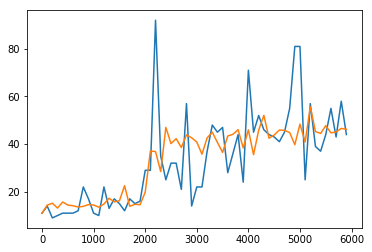

In [68]:
step = 100
x = range(0, episodes, step)
plt.plot(x, reward_list[::step])
plt.plot(x, moving_average(reward_list, w=50)[::step])
plt.show()